In [49]:
!pip install groundingdino-py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 9.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 12.2 MB/s eta 0:00:00
  Created wheel for groundingdino-py: filename=groundingdino_py-0.4.0-py2.py3-none-any.whl size=88735 sha256=f07c49294a41678ff55868a214a7609cc314fe22f316f85e0056c41693f1b792
  Stored in directory: /home/volovikova/.cac

In [1]:
import glob
import os
import sys
import torch
from datasets import Dataset, load_dataset
from peft import LoraConfig, PeftModel
import peft
from transformers import AutoModelForCausalLM, AutoTokenizer, HfArgumentParser, TrainingArguments

sys.path.append("../")
from dpo_tuning.utils.detector import get_Dino_predictions, get_ONE_PEACE_predictions, get_images
#from training_arguments import ScriptArguments

from torch.distributed.elastic.multiprocessing.errors import record
import os
import pandas as pd

from dpo_tuning.utils.detector import get_Dino_predictions, get_ONE_PEACE_predictions, get_images
from groundingdino.util.inference import load_model, load_image, predict

import re
from dpo_tuning.utils.metrics import box_iou
from torchvision.ops import box_convert

import sys
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
print(sys.executable)

/home/volovikova/mambaforge/envs/tuning/bin/python3.8


In [100]:
import sys
sys.path.append("../")
sys.path.append("../dpo_tuning")
import os
os.system('pwd')
import numpy as np
import torch
from torchvision.ops import box_convert
from groundingdino.util.inference import load_model, load_image, predict
import pandas as pd
import statistics
import re
import random
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    HfArgumentParser,
)

from PIL import Image
import cv2
import matplotlib.pyplot as plt
from training_arguments import ValidationArguments
import peft
from dpo_tuning.utils.metrics import box_iou
from dpo_tuning.utils.data import prepare_data
from dpo_tuning.utils.detector import get_images, annotate_and_save
from detectors.detectors import BaseDetector

def get_predictions(i, data, prompt, detector, path_to_imgs):
        
        dataset_bbox = torch.Tensor([[float(x) for x in re.split(',', data['true_bbox'][i][1:-1])]])
        real_bbox = box_convert(boxes=dataset_bbox, in_fmt="xywh", out_fmt="xyxy").numpy()[0] 
    
        name, img_sources, images = get_images(data['item_id'][i], path_to_imgs)
        image_metadata = {'image_np': images, 'image_pil': img_sources, 'correct': prompt, 'image_path': path_to_imgs+name}
        predicted_bbox, pred_score = detector.predict(image_metadata)
    
       # print( predicted_bbox, pred_score, prompt)
        return real_bbox, predicted_bbox, pred_score, prompt, name



/home/volovikova/cunning_manipulator/notebooks


In [46]:
import glob
checkpoints = glob.glob("../dpo_tuning/results/DINO/*")
print(checkpoints)
path_to_checkpoint = '../dpo_tuning/results/DINO/checkpoint-800'


['../dpo_tuning/results/DINO/checkpoint-5000', '../dpo_tuning/results/DINO/checkpoint-30000', '../dpo_tuning/results/DINO/checkpoint-37000', '../dpo_tuning/results/DINO/checkpoint-21000', '../dpo_tuning/results/DINO/checkpoint-1000', '../dpo_tuning/results/DINO/checkpoint-500', '../dpo_tuning/results/DINO/checkpoint-38000', '../dpo_tuning/results/DINO/checkpoint-4000', '../dpo_tuning/results/DINO/checkpoint-12000', '../dpo_tuning/results/DINO/checkpoint-17000', '../dpo_tuning/results/DINO/checkpoint-400', '../dpo_tuning/results/DINO/checkpoint-25000', '../dpo_tuning/results/DINO/checkpoint-11000', '../dpo_tuning/results/DINO/checkpoint-10000', '../dpo_tuning/results/DINO/checkpoint-13000', '../dpo_tuning/results/DINO/checkpoint-600', '../dpo_tuning/results/DINO/checkpoint-900', '../dpo_tuning/results/DINO/checkpoint-29000', '../dpo_tuning/results/DINO/checkpoint-9000', '../dpo_tuning/results/DINO/checkpoint-27000', '../dpo_tuning/results/DINO/checkpoint-2000', '../dpo_tuning/results/DI

In [143]:
model  = AutoModelForCausalLM.from_pretrained(
        "NousResearch/Llama-2-7b-chat-hf",
        low_cpu_mem_usage=True,
        torch_dtype=torch.float32,
        load_in_4bit=False,
        ).cuda()
# model = peft.PeftModel.from_pretrained(model,path_to_checkpoint, torch_dtype=torch.float16)
# model = model.merge_and_unload().cuda()
tokenizer = AutoTokenizer.from_pretrained(path_to_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [48]:
tokenizer.pad_token

'</s>'

In [49]:
datasets = glob.glob("../datasets/*")
print(datasets)
dataset = datasets[2]
print(dataset)

['../datasets/augmented_gold_4310.csv', '../datasets/new_DINO_gold_dataset_with_prompt_boxes.csv', '../datasets/DINO_gold_dataset_with_prompt_boxes_new_ranked_by_new_strategy.csv', '../datasets/augmeted_gold', '../datasets/augmented_gold_2', '../datasets/gold_descriptions_with_bboxes.csv', '../datasets/augmented_gold.csv']
../datasets/DINO_gold_dataset_with_prompt_boxes_new_ranked_by_new_strategy.csv


In [50]:
data = pd.read_csv(dataset, header=0)
data = data[:len(data)+100].reset_index(drop=True)

In [51]:
data

,id,item_id,true_bbox,prompt,correct,rejected,iou_correct,score_correct,harmonic_correct,iou_rejected,score_rejected,harmonic_rejected,description_bbox
0,0,potato_3_2,"[241, 455, 122, 96]",Paraphrase sentence: A single small red skinne...,"Sure! Here is a paraphrase of the sentence ""A...",Great job! Here's another sentence for you to...,0.800322,0.443368,0.443368,0.000000,0.255156,0.000000,[255.00111 451.65884 368.54495 548.167 ]
1,1,potato_3_2,"[241, 455, 122, 96]","Paraphrase sentence: Sure, here's a paraphras...",Sure! Here's a paraphrased sentence:\n\nEvery...,"Sure, here's a paraphrase of the sentence:\n\...",0.000000,0.368007,0.000000,0.066152,0.332694,0.000000,[254.7338 451.76404 367.89304 547.7657 ]
2,2,potato_3_2,"[241, 455, 122, 96]",Paraphrase sentence: Sure! Here's a paraphras...,"Sure! Here's a paraphrase of the sentence ""Th...",Here's a paraphrased sentence based on the or...,0.801067,0.686425,0.686425,0.800926,0.677598,0.677598,[254.74559 451.64456 367.87296 547.57245]
3,3,potato_3_2,"[241, 455, 122, 96]",Paraphrase sentence: Sure! Here's a paraphras...,"A whole, unpeeled raw potato, with its red sk...",Great job! Here's another sentence for you to...,-1.000000,0.000000,0.000000,0.000000,0.255156,0.000000,[254.84712 451.48953 367.63223 547.0346 ]
4,4,potato_3_2,"[241, 455, 122, 96]",Paraphrase sentence: Sure! Here's a paraphras...,a red potato,Sure! Here's a paraphrased version of the sen...,0.787768,0.901243,0.901243,0.802944,0.750968,0.750968,[255.03188 451.55417 367.70886 547.68024]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6999,8101,food_jar_5_3,"[280, 360, 109, 186]","Paraphrase sentence: Sure, here is a paraphra...","Sure, here is a paraphrased sentence based on...","Sure, here is a paraphrased sentence based on...",0.793459,0.845454,0.845454,0.793459,0.845454,0.845454,[292.97968 357.0603 395.4964 555.1996 ]
7000,8102,food_jar_5_3,"[280, 360, 109, 186]","Paraphrase sentence: Sure, here is a paraphra...",Sure! Here is a paraphrased sentence based on...,Sure! Here is a paraphrased sentence based on...,0.794528,0.805012,0.805012,0.794528,0.805012,0.805012,[293.0345 356.76077 394.951 554.61487]
7001,8103,food_jar_5_3,"[280, 360, 109, 186]",Paraphrase sentence: Sure! Here is a paraphra...,"Sure, here is a paraphrased sentence based on...","Sure, here is a paraphrased sentence:\n\nThis...",0.791717,0.824352,0.824352,0.787399,0.815363,0.815363,[292.58356 356.39862 394.94055 554.464 ]
7002,8104,food_jar_5_3,"[280, 360, 109, 186]","Paraphrase sentence: Sure, here is a paraphra...","Sure, here is a paraphrased sentence based on...",Sure! Here is a paraphrased sentence based on...,0.791717,0.824352,0.824352,0.794528,0.805012,0.805012,[293.1446 356.99127 394.7295 554.54425]


In [52]:
def scrap_sentence(output):
    output = output[0].split('[/INST]')[1]
    output = output.replace('\n','')
    return output.split('.')[0]

def sentence_to_vis(sentence):
    words = sentence.split()
    new_sentence = ""
    for i,word in enumerate(words):
        new_sentence += f"{word} "
        if i%3 == 0:
            new_sentence += "\n"
    return new_sentence

In [96]:

def split_prompt(prompt):
    if ":" in prompt:
        return prompt.split(":")[1]
    return prompt
    
def prepare_h_prompt(promt):
    if ":" in promt:
        if promt.count(":") == 2:
            parts = promt.split(":")
            return f"{parts[0]}:{parts[2]}"
        else:
            parts = promt.split(":")
            return f"{parts[0]}:{parts[1]}"
    return prompt

def reframe(my_prompt):
    prompt = tokenizer(my_prompt,return_tensors="pt").input_ids
    instruction  = my_prompt.replace("[INST] Paraphrase sentence:", "").replace("[/INST]", "").replace("\n", "")
    output_tensor = model.generate(torch.Tensor(prompt).cuda(),  max_new_tokens=300, do_sample=False)
    output = tokenizer.batch_decode(output_tensor, skip_special_tokens=True)
    return scrap_sentence(output)

i = 99
my_prompt = prepare_h_prompt(f"[INST] {data['prompt'][i]} [/INST]")


In [90]:
my_prompt

'[INST] Paraphrase sentence:\n\nA specialized device used to open cans with a blue handle [/INST]'

In [122]:

path_to_imgs='../gold/images/RGB_raw/'
detector = BaseDetector("Dino")

i = 80
my_prompt = prepare_h_prompt(f"[INST] {data['prompt'][i]} [/INST]")
output = reframe(my_prompt)
prompt_tuned = split_prompt(output)
prompt = split_prompt(my_prompt)

real_bbox, prompt_bbox, prompt_pred_score, output, name = get_predictions(i, data, prompt, detector, path_to_imgs)
real_bbox, predicted_bbox, pred_score, output, name = get_predictions(i, data, prompt_tuned, detector, path_to_imgs)


final text_encoder_type: bert-base-uncased


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


a [241. 455. 363. 551.]
b [254.09085 450.72415 365.69376 545.64545]
a [241. 455. 363. 551.]
b [255.06726 451.50436 365.01263 544.54614]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'GROUND TRUE BBOX')

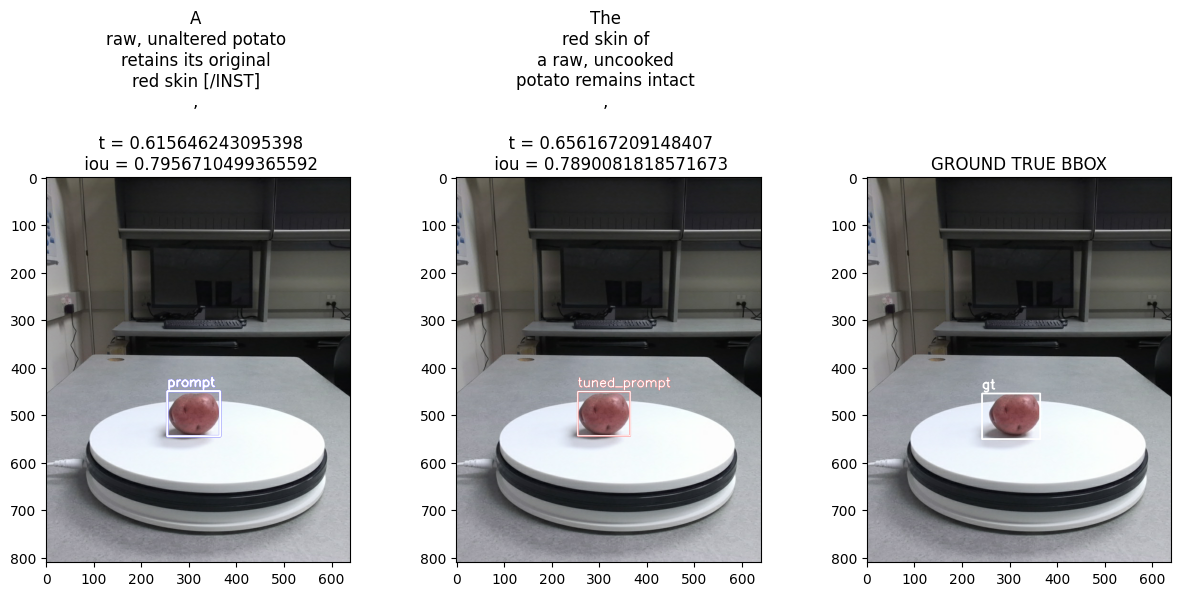

In [123]:
plt.figure(figsize=(15,5))
iou_score_old = (float(box_iou(real_bbox, prompt_bbox)))
iou_score_tuned = (float(box_iou(real_bbox, predicted_bbox)))

image = plt.imread(path_to_imgs+name)
image = cv2.rectangle(image, (int(prompt_bbox[0]), int(prompt_bbox[1])), (int(prompt_bbox[2]), int(prompt_bbox[3])), (0, 0, 255), 4)
cv2.putText(image, 'prompt', (int(prompt_bbox[0]), int(prompt_bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 4)
plt.subplot(1,3,1)
plt.imshow(image)
plt.title(f"{sentence_to_vis(prompt)}, \n \n  t = {prompt_pred_score} \n iou = {iou_score_old}")


image = plt.imread(path_to_imgs+name)
image = cv2.rectangle(image, (int(predicted_bbox[0]), int(predicted_bbox[1])), (int(predicted_bbox[2]), int(predicted_bbox[3])), (255, 0, 0), 2)
cv2.putText(image, 'tuned_prompt', (int(predicted_bbox[0]), int(predicted_bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)
plt.subplot(1,3,2)
plt.imshow(image)
plt.title(f"{sentence_to_vis(prompt_tuned)}, \n \n  t = {pred_score} \n iou = {iou_score_tuned}")

image = plt.imread(path_to_imgs+name)
image = cv2.rectangle(image, (int(real_bbox[0]), int(real_bbox[1])), (int(real_bbox[2]), int(real_bbox[3])), (1,255,1), 2)
cv2.putText(image, 'gt', (int(real_bbox[0]), int(real_bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (1,255,1), 2)
plt.subplot(1,3,3)
plt.imshow(image)
plt.title("GROUND TRUE BBOX")

In [144]:
import tqdm
from dpo_tuning.utils.metrics import box_iou

path_to_imgs='../gold/images/RGB_raw/'
detector = BaseDetector("Dino")

score_old = []
score_tuned = []

iou_score_old = []
iou_score_tuned = []

for i in tqdm.tqdm(range(90)):
    
    my_prompt = prepare_h_prompt(f"[INST] {data['prompt'][i]} [/INST]")
    try:
        output = reframe(my_prompt)
    except:
        continue
    prompt_tuned = split_prompt(output)
    prompt = split_prompt(my_prompt)
    
    real_bbox, prompt_bbox, prompt_pred_score, output, name = get_predictions(i, data, prompt, detector, path_to_imgs)
    real_bbox, predicted_bbox, pred_score, output, name = get_predictions(i, data, prompt_tuned, detector, path_to_imgs)
    
    iou_score_old.append(float(box_iou(real_bbox, prompt_bbox)))
    iou_score_tuned.append(float(box_iou(real_bbox, predicted_bbox)))
    
    score_old.append(prompt_pred_score)
    score_tuned.append(pred_score)
    
    

final text_encoder_type: bert-base-uncased


  0%|                                                                                                                                                                                | 0/90 [00:00<?, ?it/s]/home/volovikova/mambaforge/envs/tuning/lib/python3.8/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/home/volovikova/mambaforge/envs/tuning/lib/python3.8/site-packages/transformers/modeling_utils.py:881: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/volovikova/mambaforge/envs/tuning/lib/python3.8/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass i

a [241. 455. 363. 551.]
b [255.12698 451.5247  367.15182 546.7494 ]
a [241. 455. 363. 551.]
b [255.142   451.8993  367.10696 546.9031 ]


  2%|███▋                                                                                                                                                                    | 2/90 [00:07<05:14,  3.58s/it]

a [241. 455. 363. 551.]
b [254.83113 451.40622 367.11816 547.1075 ]
a [241. 455. 363. 551.]
b [254.6911  451.36343 368.242   547.83264]


  3%|█████▌                                                                                                                                                                  | 3/90 [00:09<04:02,  2.79s/it]

a [241. 455. 363. 551.]
b [254.58722 450.9797  367.11377 546.3809 ]
a [241. 455. 363. 551.]
b [254.79643 451.0358  366.70392 546.27515]


  4%|███████▍                                                                                                                                                                | 4/90 [00:10<03:10,  2.22s/it]

a [241. 455. 363. 551.]
b [254.38528 450.61807 366.1453  545.72284]
a [241. 455. 363. 551.]
b [254.8132  451.20633 367.04984 546.2787 ]


  6%|█████████▎                                                                                                                                                              | 5/90 [00:12<02:59,  2.11s/it]

a [241. 455. 363. 551.]
b [254.85202 451.18442 365.29538 545.0704 ]
a [241. 455. 363. 551.]
b [254.86847 451.17682 368.3374  547.4748 ]


  7%|███████████▏                                                                                                                                                            | 6/90 [00:14<02:49,  2.01s/it]

a [241. 455. 363. 551.]
b [255.20633 451.52655 366.6384  545.91266]
a [241. 455. 363. 551.]
b [255.10928 451.74817 367.1633  546.64166]


  8%|█████████████                                                                                                                                                           | 7/90 [00:15<02:34,  1.86s/it]

a [247. 472. 420. 555.]
b [244.28525 464.55554 423.18307 557.8705 ]
a [247. 472. 420. 555.]
b [244.91089 466.58643 424.95123 559.5464 ]


  9%|██████████████▉                                                                                                                                                         | 8/90 [00:18<02:58,  2.17s/it]

a [247. 472. 420. 555.]
b [244.79504 466.20016 425.25122 559.8759 ]
a [247. 472. 420. 555.]
b [244.99341 466.39008 425.33948 559.7872 ]


 10%|████████████████▊                                                                                                                                                       | 9/90 [00:20<02:53,  2.15s/it]

a [247. 472. 420. 555.]
b [ 76.720764 466.36832  591.55865  751.57935 ]
a [247. 472. 420. 555.]
b [245.01509 466.64456 424.1305  559.11743]


 11%|██████████████████▌                                                                                                                                                    | 10/90 [00:22<02:35,  1.94s/it]

a [247. 472. 420. 555.]
b [244.43912 465.13922 424.5422  559.29474]
a [247. 472. 420. 555.]
b [245.02109 466.70523 425.35178 559.668  ]


 12%|████████████████████▍                                                                                                                                                  | 11/90 [00:26<03:18,  2.52s/it]

a [272. 473. 393. 561.]
b [281.1074  470.10614 395.84048 555.59454]
a [272. 473. 393. 561.]
b [281.25113 470.22815 396.76163 556.3097 ]


 13%|██████████████████████▎                                                                                                                                                | 12/90 [00:28<03:12,  2.47s/it]

a [272. 473. 393. 561.]
b [281.2147  469.854   395.39243 554.9407 ]
a [272. 473. 393. 561.]
b [281.80292 471.06686 396.71362 556.1568 ]


 14%|████████████████████████                                                                                                                                               | 13/90 [00:32<03:43,  2.90s/it]

a [272. 473. 393. 561.]
b [ 77.054474 467.4568   592.5145   751.109   ]
a [272. 473. 393. 561.]
b [281.66827 471.0475  397.0551  556.7648 ]


 17%|███████████████████████████▊                                                                                                                                           | 15/90 [00:37<03:36,  2.89s/it]

a [272. 473. 393. 561.]
b [281.0466  470.29007 397.11923 557.27356]
a [272. 473. 393. 561.]
b [281.04593 470.3937  397.618   557.5207 ]


 18%|█████████████████████████████▋                                                                                                                                         | 16/90 [00:40<03:34,  2.90s/it]

a [241. 490. 493. 572.]
b [ 71.616455 452.1579   596.25085  753.48175 ]
a [241. 490. 493. 572.]
b [241.8061  485.19476 496.49554 575.9428 ]


 19%|███████████████████████████████▌                                                                                                                                       | 17/90 [00:43<03:34,  2.94s/it]

a [241. 490. 493. 572.]
b [241.64664 485.11633 495.46384 575.2971 ]
a [241. 490. 493. 572.]
b [241.79199 484.99753 495.97778 575.7223 ]


 20%|█████████████████████████████████▍                                                                                                                                     | 18/90 [00:45<03:14,  2.71s/it]

a [241. 490. 493. 572.]
b [241.82367 485.2017  494.46875 574.13574]
a [241. 490. 493. 572.]
b [241.64592 485.1506  496.3371  576.04565]


 21%|███████████████████████████████████▎                                                                                                                                   | 19/90 [00:48<03:18,  2.80s/it]

a [241. 490. 493. 572.]
b [241.40236 484.80704 495.32013 575.28406]
a [241. 490. 493. 572.]
b [241.8552  485.08035 494.82376 574.5255 ]


 22%|█████████████████████████████████████                                                                                                                                  | 20/90 [00:51<03:01,  2.59s/it]

a [241. 490. 493. 572.]
b [241.81747 484.95117 494.2239  574.056  ]
a [241. 490. 493. 572.]
b [241.65152 485.0611  496.02744 575.75946]


 23%|██████████████████████████████████████▉                                                                                                                                | 21/90 [00:54<03:08,  2.73s/it]

a [241. 490. 493. 572.]
b [241.6766  485.13596 496.84854 576.39026]
a [241. 490. 493. 572.]
b [242.01949 485.2879  496.92352 576.3752 ]


 24%|████████████████████████████████████████▊                                                                                                                              | 22/90 [00:57<03:14,  2.86s/it]

a [171. 471. 465. 545.]
b [167.57101 466.76215 467.5151  547.80005]
a [171. 471. 465. 545.]
b [168.69109 468.41852 469.22266 550.37396]


 26%|██████████████████████████████████████████▋                                                                                                                            | 23/90 [01:00<03:27,  3.10s/it]

a [171. 471. 465. 545.]
b [168.31113 468.10516 469.29593 549.83374]
a [171. 471. 465. 545.]
b [168.49817 468.46164 469.4223  550.1892 ]


 27%|████████████████████████████████████████████▌                                                                                                                          | 24/90 [01:03<03:07,  2.85s/it]

a [171. 471. 465. 545.]
b [167.9007  467.43057 468.26196 548.5619 ]
a [171. 471. 465. 545.]
b [168.31491 468.2547  468.76224 549.82605]


 28%|██████████████████████████████████████████████▍                                                                                                                        | 25/90 [01:06<03:22,  3.12s/it]

a [171. 471. 465. 545.]
b [168.14221 468.0744  468.07983 549.60236]
a [171. 471. 465. 545.]
b [168.68297 467.93652 468.81995 549.7509 ]


 29%|████████████████████████████████████████████████▏                                                                                                                      | 26/90 [01:09<03:03,  2.86s/it]

a [241. 455. 363. 551.]
b [255.2951  451.36456 365.00494 544.85693]
a [241. 455. 363. 551.]
b [254.97678 451.32    364.77194 544.3465 ]


 31%|███████████████████████████████████████████████████▉                                                                                                                   | 28/90 [01:22<04:27,  4.32s/it]

a [247. 472. 420. 555.]
b [243.72568 463.4465  423.30185 557.62683]
a [247. 472. 420. 555.]
b [ 76.075836 463.2024   591.0591   750.43884 ]


 32%|█████████████████████████████████████████████████████▊                                                                                                                 | 29/90 [01:23<03:27,  3.41s/it]

a [247. 472. 420. 555.]
b [ 75.49841 464.4096  592.9297  752.0368 ]
a [247. 472. 420. 555.]
b [  4.218231 465.56494  593.9689   753.1123  ]


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 30/90 [01:25<03:10,  3.18s/it]

a [247. 472. 420. 555.]
b [245.00793 467.0565  424.23468 558.82495]
a [247. 472. 420. 555.]
b [ 76.86203 466.81512 593.1776  752.5921 ]


 34%|█████████████████████████████████████████████████████████▌                                                                                                             | 31/90 [01:28<02:57,  3.01s/it]

a [247. 472. 420. 555.]
b [ 76.01178 465.02728 592.8558  752.029  ]
a [247. 472. 420. 555.]
b [244.78165 467.14783 424.5021  559.29456]


 36%|███████████████████████████████████████████████████████████▍                                                                                                           | 32/90 [01:30<02:38,  2.74s/it]

a [247. 472. 420. 555.]
b [244.73065 466.45953 424.41125 558.9058 ]
a [247. 472. 420. 555.]
b [244.90689 467.0886  424.5986  559.20544]


 37%|█████████████████████████████████████████████████████████████▏                                                                                                         | 33/90 [01:34<02:51,  3.01s/it]

a [247. 472. 420. 555.]
b [ 75.01544 463.72018 592.3278  751.4468 ]
a [247. 472. 420. 555.]
b [  4.350952 466.33588  592.61383  752.3769  ]


 38%|███████████████████████████████████████████████████████████████                                                                                                        | 34/90 [01:36<02:28,  2.65s/it]

a [272. 473. 393. 561.]
b [280.4417  469.02414 395.50488 555.4744 ]
a [272. 473. 393. 561.]
b [280.35782 468.4546  395.3124  555.7792 ]


 39%|████████████████████████████████████████████████████████████████▉                                                                                                      | 35/90 [01:38<02:29,  2.71s/it]

a [272. 473. 393. 561.]
b [280.5747  468.86407 395.39484 555.11316]
a [272. 473. 393. 561.]
b [280.37674 468.88138 395.37448 555.2216 ]


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 36/90 [01:40<02:14,  2.50s/it]

a [272. 473. 393. 561.]
b [280.78903 469.5659  395.1465  554.97516]
a [272. 473. 393. 561.]
b [280.00156 468.46973 395.8517  555.72437]


 41%|████████████████████████████████████████████████████████████████████▋                                                                                                  | 37/90 [01:43<02:19,  2.64s/it]

a [272. 473. 393. 561.]
b [280.40823 468.9466  395.4639  555.612  ]
a [272. 473. 393. 561.]
b [280.70923 469.48245 395.0475  555.1232 ]


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                | 38/90 [01:46<02:14,  2.59s/it]

a [272. 473. 393. 561.]
b [ 75.24414 462.98322 591.5681  750.6069 ]
a [272. 473. 393. 561.]
b [280.61548 469.47507 395.21777 555.0881 ]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                              | 39/90 [01:49<02:12,  2.60s/it]

a [272. 473. 393. 561.]
b [280.61035 469.288   395.55243 555.3863 ]
a [272. 473. 393. 561.]
b [280.77618 469.93268 395.2486  555.3752 ]


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                            | 40/90 [01:51<02:10,  2.61s/it]

a [241. 490. 493. 572.]
b [241.7543 484.4254 494.2891 574.3927]
a [241. 490. 493. 572.]
b [242.27094 485.6026  493.3363  572.73224]


 46%|████████████████████████████████████████████████████████████████████████████                                                                                           | 41/90 [01:53<01:55,  2.35s/it]

a [241. 490. 493. 572.]
b [241.41399 484.61197 493.8426  573.4592 ]
a [241. 490. 493. 572.]
b [242.05179 485.37854 493.6412  573.136  ]


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                         | 42/90 [01:55<01:44,  2.18s/it]

a [241. 490. 493. 572.]
b [240.98773 483.83566 494.12762 574.17175]
a [241. 490. 493. 572.]
b [241.49466 483.8977  493.53195 573.7615 ]


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                       | 43/90 [01:56<01:33,  1.99s/it]

a [241. 490. 493. 572.]
b [241.43857 484.68567 493.87546 574.1642 ]
a [241. 490. 493. 572.]
b [  6.8313904 462.6529    592.9834    749.7967   ]


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 44/90 [01:58<01:24,  1.84s/it]

a [241. 490. 493. 572.]
b [  7.7322693 459.55902   594.16284   751.14325  ]
a [241. 490. 493. 572.]
b [240.73788 484.33383 494.61966 574.9984 ]


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 45/90 [02:00<01:26,  1.92s/it]

a [241. 490. 493. 572.]
b [239.20468 482.60657 495.47983 576.7871 ]
a [241. 490. 493. 572.]
b [  5.008606 465.15704  591.7525   749.87164 ]


 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 46/90 [02:02<01:25,  1.94s/it]

a [171. 471. 465. 545.]
b [167.47614 466.8114  467.5647  547.6896 ]
a [171. 471. 465. 545.]
b [167.84857 466.98523 467.06104 547.8323 ]


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 47/90 [02:05<01:35,  2.23s/it]

a [171. 471. 465. 545.]
b [167.40968 467.0379  467.00732 547.7874 ]
a [171. 471. 465. 545.]
b [168.20538 467.9018  468.1173  549.35455]


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                              | 48/90 [02:07<01:36,  2.30s/it]

a [171. 471. 465. 545.]
b [167.71304 467.12164 467.10135 548.24146]
a [171. 471. 465. 545.]
b [167.55057 467.00598 468.3353  549.3907 ]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 49/90 [02:10<01:37,  2.39s/it]

a [171. 471. 465. 545.]
b [168.33275 467.80652 468.56348 549.7569 ]
a [171. 471. 465. 545.]
b [169.0026  468.5923  469.16245 550.17145]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 50/90 [02:13<01:45,  2.63s/it]

a [171. 471. 465. 545.]
b [169.03557 468.7325  468.46643 549.5698 ]
a [171. 471. 465. 545.]
b [168.55771 468.33398 468.2421  549.3841 ]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 51/90 [02:15<01:34,  2.42s/it]

a [171. 471. 465. 545.]
b [168.23901 467.8166  469.10358 550.4586 ]
a [171. 471. 465. 545.]
b [169.12973 468.61923 468.98257 550.5058 ]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 52/90 [02:18<01:39,  2.63s/it]

a [241. 455. 363. 551.]
b [255.26372 451.05078 365.20517 544.82697]
a [241. 455. 363. 551.]
b [254.96051 451.58417 364.70575 543.97516]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 53/90 [02:20<01:28,  2.39s/it]

a [241. 455. 363. 551.]
b [253.39825 449.55045 366.22705 546.3529 ]
a [241. 455. 363. 551.]
b [254.99902 451.49048 364.68286 544.1694 ]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 54/90 [02:22<01:27,  2.42s/it]

a [241. 455. 363. 551.]
b [253.3558  449.65744 366.2372  546.20264]
a [241. 455. 363. 551.]
b [254.98009 451.48758 364.7053  544.06323]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 55/90 [02:25<01:23,  2.40s/it]

a [241. 455. 363. 551.]
b [253.19733 448.76013 366.14642 546.8658 ]
a [241. 455. 363. 551.]
b [254.62039 451.26953 365.13406 544.2806 ]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 56/90 [02:26<01:14,  2.20s/it]

a [241. 455. 363. 551.]
b [253.44177 450.04303 366.03235 546.1477 ]
a [241. 455. 363. 551.]
b [253.89404 450.44678 365.51813 545.3216 ]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 57/90 [02:29<01:18,  2.38s/it]

a [241. 455. 363. 551.]
b [252.91785 449.17804 366.56757 546.8541 ]
a [241. 455. 363. 551.]
b [ 74.535   445.00702 595.433   751.736  ]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 58/90 [02:31<01:14,  2.32s/it]

a [247. 472. 420. 555.]
b [244.14319 463.6765  423.0464  558.04596]
a [247. 472. 420. 555.]
b [244.82533 465.31863 422.37958 556.94995]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 59/90 [02:42<02:27,  4.74s/it]

a [247. 472. 420. 555.]
b [244.91467 465.61807 423.14575 558.098  ]
a [247. 472. 420. 555.]
b [244.62439 466.254   425.35815 560.7884 ]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 60/90 [02:44<02:01,  4.07s/it]

a [247. 472. 420. 555.]
b [ 73.14023 455.81995 593.8889  752.7285 ]
a [247. 472. 420. 555.]
b [246.13454 295.935   420.9497  321.99896]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 61/90 [02:47<01:46,  3.68s/it]

a [272. 473. 393. 561.]
b [280.23703 468.76212 395.6473  555.64404]
a [272. 473. 393. 561.]
b [280.41238 468.92398 395.1741  555.2257 ]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 62/90 [02:50<01:33,  3.34s/it]

a [272. 473. 393. 561.]
b [280.044   467.95282 395.93732 555.9673 ]
a [272. 473. 393. 561.]
b [280.06827 468.7723  395.8419  556.0611 ]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 63/90 [02:52<01:22,  3.04s/it]

a [272. 473. 393. 561.]
b [279.8901  468.35654 396.19687 556.43964]
a [272. 473. 393. 561.]
b [280.50275 469.08862 396.87787 557.3727 ]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 64/90 [02:55<01:20,  3.11s/it]

a [272. 473. 393. 561.]
b [280.16806 468.1498  395.9642  556.25165]
a [272. 473. 393. 561.]
b [280.4991  470.34152 396.08017 557.32263]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 65/90 [02:57<01:11,  2.86s/it]

a [272. 473. 393. 561.]
b [279.83627 468.14853 396.37106 556.86383]
a [272. 473. 393. 561.]
b [280.93777 470.604   397.6876  558.0895 ]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 66/90 [03:00<01:08,  2.87s/it]

a [272. 473. 393. 561.]
b [280.6506  469.36868 396.86844 557.3666 ]
a [272. 473. 393. 561.]
b [280.59912 469.31757 395.88672 556.2629 ]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 67/90 [03:03<01:03,  2.75s/it]

a [241. 490. 493. 572.]
b [242.02866 484.64233 494.14902 573.9678 ]
a [241. 490. 493. 572.]
b [242.13753 485.48846 493.5338  573.21893]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 68/90 [03:06<00:59,  2.72s/it]

a [241. 490. 493. 572.]
b [241.37772 484.41214 493.8832  574.2638 ]
a [241. 490. 493. 572.]
b [240.96005 484.5818  494.46567 574.88403]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 69/90 [03:08<00:52,  2.51s/it]

a [241. 490. 493. 572.]
b [241.47273 484.55096 494.71814 574.8221 ]
a [241. 490. 493. 572.]
b [241.96912 485.2673  493.8014  573.4078 ]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 70/90 [03:10<00:51,  2.60s/it]

a [241. 490. 493. 572.]
b [ 73.54028 465.75812 591.5253  750.70905]
a [241. 490. 493. 572.]
b [241.78703 485.12778 493.65912 573.431  ]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 71/90 [03:12<00:45,  2.41s/it]

a [241. 490. 493. 572.]
b [241.50531 484.6706  494.05524 573.8968 ]
a [241. 490. 493. 572.]
b [  3.6960144 464.08002   592.7223    751.28937  ]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 72/90 [03:15<00:46,  2.56s/it]

a [241. 490. 493. 572.]
b [  3.683075 467.1325   592.33496  750.7808  ]
a [241. 490. 493. 572.]
b [  3.782135 464.4975   592.12573  750.74664 ]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 73/90 [03:18<00:42,  2.52s/it]

a [171. 471. 465. 545.]
b [166.59091 465.17722 468.13553 548.7367 ]
a [171. 471. 465. 545.]
b [168.10587 467.4039  466.64792 547.0537 ]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 74/90 [03:19<00:36,  2.28s/it]

a [171. 471. 465. 545.]
b [167.82944 467.24026 466.9827  547.6885 ]
a [171. 471. 465. 545.]
b [167.50061 467.01184 467.518   548.6041 ]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 75/90 [03:22<00:36,  2.46s/it]

a [171. 471. 465. 545.]
b [167.43365 467.01758 467.21295 548.0849 ]
a [171. 471. 465. 545.]
b [167.19888 466.71686 467.40207 548.3443 ]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 76/90 [03:24<00:32,  2.29s/it]

a [171. 471. 465. 545.]
b [167.37332 466.7538  467.18484 548.1496 ]
a [171. 471. 465. 545.]
b [ 76.838715 464.6015   592.38135  750.9528  ]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 77/90 [03:26<00:27,  2.09s/it]

a [171. 471. 465. 545.]
b [166.83014 466.45013 467.35315 548.26447]
a [171. 471. 465. 545.]
b [167.60869 467.11972 466.90393 547.5294 ]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 78/90 [03:29<00:28,  2.39s/it]

a [171. 471. 465. 545.]
b [167.9602  467.44092 466.9646  547.2169 ]
a [171. 471. 465. 545.]
b [168.46591 468.16925 467.63663 548.49023]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 79/90 [03:31<00:25,  2.30s/it]

a [241. 455. 363. 551.]
b [255.19473 451.2376  365.22574 544.95996]
a [241. 455. 363. 551.]
b [254.95241 451.73373 364.66333 544.7279 ]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 81/90 [03:35<00:19,  2.20s/it]

a [241. 455. 363. 551.]
b [254.09085 450.72415 365.69376 545.64545]
a [241. 455. 363. 551.]
b [255.09404 451.9366  365.963   545.95074]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 82/90 [03:37<00:16,  2.00s/it]

a [241. 455. 363. 551.]
b [254.46538 451.1178  365.43384 545.65045]
a [241. 455. 363. 551.]
b [254.99698 451.87622 366.60892 546.61456]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 83/90 [03:40<00:17,  2.43s/it]

a [247. 472. 420. 555.]
b [244.6414 465.047  422.7276 557.1469]
a [247. 472. 420. 555.]
b [  3.3717957 465.4842    593.38477   752.2205   ]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 84/90 [03:43<00:14,  2.39s/it]

a [247. 472. 420. 555.]
b [244.42188 464.90872 422.81293 557.6102 ]
a [247. 472. 420. 555.]
b [244.83029 466.6416  423.543   558.2875 ]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 85/90 [03:46<00:13,  2.76s/it]

a [247. 472. 420. 555.]
b [ 74.05789 454.38412 595.17847 750.6483 ]
a [247. 472. 420. 555.]
b [244.11438 294.88153 420.54712 321.99408]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 86/90 [03:48<00:10,  2.61s/it]

a [272. 473. 393. 561.]
b [280.12634 468.80234 395.97266 556.04175]
a [272. 473. 393. 561.]
b [280.51456 469.2724  395.20602 555.4445 ]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 87/90 [03:51<00:08,  2.69s/it]

a [272. 473. 393. 561.]
b [279.9937  468.57266 395.7838  556.43317]
a [272. 473. 393. 561.]
b [280.13    469.05557 396.04443 556.5141 ]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 88/90 [03:53<00:04,  2.32s/it]

a [272. 473. 393. 561.]
b [ 74.69446 462.81903 592.15    750.4255 ]
a [272. 473. 393. 561.]
b [280.88965 469.94327 396.67798 556.8952 ]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 89/90 [03:55<00:02,  2.42s/it]

a [272. 473. 393. 561.]
b [280.66153 470.10776 397.09122 557.7333 ]
a [272. 473. 393. 561.]
b [ 76.02643 464.3385  593.6374  751.9961 ]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [03:58<00:00,  2.65s/it]

a [272. 473. 393. 561.]
b [280.87817 470.33243 397.0697  557.38306]
a [272. 473. 393. 561.]
b [280.59692 469.8494  396.79254 557.36035]


In [145]:
print("MEAN-score-old", np.mean(score_old))
print("MEAN-score-tuned", np.mean(score_tuned))

print()

print("MEAN-score-old", np.mean(iou_score_old))
print("MEAN-score-tuned", np.mean(iou_score_tuned))

MEAN-score-old 0.5739665591511233
MEAN-score-tuned 0.5929911969036892

MEAN-score-old 0.7405949299731299
MEAN-score-tuned 0.7312483267750324


In [133]:
my_prompt

"[INST] Paraphrase sentence:\n\nThe tape measure showcases an aesthetically pleasing color scheme, featuring bold and vibrant yellow and black colors that grab the viewer's attention [/INST]"

In [146]:
import pandas as pd
import numpy as np


# Создание DataFrame
df = pd.DataFrame({
    "MEAN-score-old": [np.mean(score_old)],
    "MEAN-score-tuned": [np.mean(score_tuned)],
    "MEAN-iou-score-old": [np.mean(iou_score_old)],
    "MEAN-iou-score-tuned": [np.mean(iou_score_tuned)]
})

# Функция для выделения максимального значения в строке
def highlight_max(s):

    return [None, 'font-weight: bold',None, 'font-weight: bold']

# Применяем стилизацию для выделения лучшего значения в каждой паре
styled_df = df.style.apply(highlight_max, axis=1)
styled_df

,MEAN-score-old,MEAN-score-tuned,MEAN-iou-score-old,MEAN-iou-score-tuned
0,0.573967,0.592991,0.740595,0.731248
